# Housing Regression

This notebook predicts housing prices in the Kaggle pratice competition "House Prices: Advanced Regression Techniques." It uses the Scitkit-learn library for data preprocessing and various utility functions, the Keras library to implement neural networks, and the numpy library for various data handling functions. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
# Get data
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Dataset is small, can run correlation matrix to see relationships for numeric features
corr_matrix = data.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [4]:
# Shuffle data in case it's organized in some way
def shuffleData(data):
    return data.sample(frac=1).reset_index(drop=True)
    
data = shuffleData(data)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,24,120,RM,44.0,4224,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,129900
1,589,20,RL,65.0,25095,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Partial,143000
2,161,20,RL,NaN,11120,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,162500
3,1368,160,RM,41.0,2665,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,127000
4,1224,20,RL,89.0,10680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2006,WD,Normal,137900


In [5]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Can adjust train/test split to try to improve performance
X_train, X_test, y_train, y_test = train_test_split(data.drop('SalePrice', axis=1),data['SalePrice'], 
                                                    test_size=0.28, shuffle=True)

# Scale SalePrice
max_SalePrice = y_train.max()
y_train = y_train / max_SalePrice
y_test = y_test / max_SalePrice

## Feature Handling

Here the features are split into 5 groups. The numeric features are already compatible with nearly all machine learning algorithms and the only preprocessing that needs to be done is to scale them. The ordinal correlated group contains categoric features
with simple ascending or descending correlations. These are mostly features with a set of categories like Poor, Average, Good, and Excellent. The relationship between these categories is accurately simulated by an ordinal encoding. The uncorrelated group
contains categoric features where there is little to no relationship between each category. These are mostly features where each category is a different type of a component of the house, roof style, garage type, etc. The embed correlated group contains
features that do have relationships but those relationships are not accurately simulated by an ordinal encoding. For example the location of the house can be an important factor in it's sale price but the relationship between sale price and location would 
be best simualted by a 2d, or sometimes 3d, map. These features are encoded using learned embeddings, which are mostly used to map the relationships between words in language processing, with fewer embed dimensions to capture these more complex relationships. The last groupd are features that require additional preprocessing steps to be put into the above categories or that are dropped.

In [6]:
# Split features into types based on how we will preprocess them
# Refer to data_description.txt for more info on features

# Numeric features
# Note: The description is incorrect Kitchen and Bedroom are labeled KitchenAbvGr and BedroomAbvGr
num_features = ["LotFrontage", "LotArea", "YearBuilt", "OverallQual", "OverallCond", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
               "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", 
                "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "YrSold","YearRemodAdd"]

# Categoric features that have simple, (a>b>c), correlations and can be ordinally encoded, NOTE: Be careful about order
cat_features_ordcorr = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", 
                        "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "LotShape", "LandContour", "LandSlope"]

# Categoric features that likely don't have any correlation for use with one hot encoders
cat_features_uncorr = ["Street", "Alley", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", "CentralAir", "GarageType", 
                       "MiscFeature", "SaleType", "SaleCondition"]

# Categoric features that likely have some complex correlations for use with learned embedding
cat_features_embcorr = ["MSSubClass", "MSZoning", "Utilities", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle"]

# Features that may require different preprocessing steps than the above
# Dropping MoSold, month sold
odd_features = ["MoSold"]

In [7]:
# Scale numeric data

from sklearn.preprocessing import MinMaxScaler

# Grab feature subsets from each dataset, training, testing, and submission test
num_enc_X_train = X_train.loc[:, num_features]
num_enc_X_test = X_test.loc[:, num_features]
num_test = test.loc[:, num_features]

# Filling NaNs with 0 as they likely signify an absence of the feature in the home
num_enc_X_train.fillna(0, inplace=True)
num_enc_X_test.fillna(0, inplace=True)
num_test.fillna(0, inplace=True)

# Scale numeric data. Only fit once so all datasets will have the same encoding
mm_scaler = MinMaxScaler()
num_enc_X_train = mm_scaler.fit_transform(num_enc_X_train)
num_enc_X_test = mm_scaler.transform(num_enc_X_test)
num_test = mm_scaler.transform(num_test)

In [8]:
# Ordinal encoding

from sklearn.preprocessing import OrdinalEncoder

# Define category order for each feature, refer to data_description.txt for more info on features and categories
feature_cat_pairs = [('ExterQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('ExterCond', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('BsmtQual', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('BsmtCond', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('BsmtExposure', ['NA', 'No', 'Mn', 'Av', 'Gd']),
                  ('BsmtFinType1', ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']),
                  ('BsmtFinType2', ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']),
                  ('HeatingQC', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('KitchenQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('Functional', ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']),
                  ('FireplaceQu', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('GarageFinish', ['NA', 'Unf', 'RFn', 'Fin']),
                  ('GarageQual', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('GarageCond', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('PavedDrive', ['N', 'P', 'Y']),
                  ('PoolQC', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
                  ('Fence', ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']),
                  ('LotShape', ['IR3', 'IR2', 'IR1', 'Reg']),
                  ('LandContour', ['Low', 'HLS', 'Bnk', 'Lvl']),
                  ('LandSlope', ['Sev', 'Mod', 'Gtl'])
                 ]

def encodeDataOrdinalWithCategories(data, feature_cat_pairs):
    """
    Ordinally encodes data using given feature, category pairs.
    """
    
    scaler = MinMaxScaler()
    ord_enc_data = np.zeros((len(data), len(feature_cat_pairs)))
    
    for i, pair in enumerate(feature_cat_pairs, start=0):
        feature = data.loc[:, (pair[0])].copy(deep=False)
        
        # Replace NaNs with 'NA' string if that is a category otherwise replace with most common category
        if 'NA' in pair[1]:
            feature.fillna('NA', inplace=True)
        else:
            feature.fillna(feature.value_counts().index[0], inplace=True)
        
        ord_enc = OrdinalEncoder(categories=[pair[1]])
        
        transformed_data = scaler.fit_transform(ord_enc.fit_transform(feature.to_numpy().reshape(-1,1)))
        
        # Copy values into output np array, can probably improve this
        for j, value in enumerate(transformed_data, start=0):
            ord_enc_data[j][i] = value
        
    return ord_enc_data

# Encode data. These can be fit separately as their encodings are based on feature_cat_pairs
ord_enc_X_train = encodeDataOrdinalWithCategories(X_train, feature_cat_pairs)
ord_enc_X_test = encodeDataOrdinalWithCategories(X_test, feature_cat_pairs)
ord_test = encodeDataOrdinalWithCategories(test, feature_cat_pairs)

In [9]:
# One hot encoding 

from sklearn.preprocessing import OneHotEncoder

# handle_unkown='ignore' will make it ignore new categories in test data so model won't break
onehot_enc = OneHotEncoder(handle_unknown='ignore')

# Grab feature subsets
onehot_enc_X_train = X_train.loc[:, cat_features_uncorr].copy(deep=False)
onehot_enc_X_test = X_test.loc[:, cat_features_uncorr].copy(deep=False)
onehot_test = test.loc[:, cat_features_uncorr].copy(deep=False)

# Fill NaNs with Na string
onehot_enc_X_train.fillna("Na", inplace=True)
onehot_enc_X_test.fillna("Na", inplace=True)
onehot_test.fillna("Na", inplace=True)

# Fit and transform data into sparse matrices. Only fit once so all datasets will have the same encoding.
onehot_enc_X_train = onehot_enc.fit_transform(onehot_enc_X_train)
onehot_enc_X_test = onehot_enc.transform(onehot_enc_X_test)
onehot_test = onehot_enc.transform(onehot_test)

In [10]:
# Learned embedding encoding

from numpy import unique

scaler = MinMaxScaler()
emb_enc_X_train = list()
emb_enc_X_test = list()
emb_test = list()


for i, col in enumerate(cat_features_embcorr):
    
    # Grab feature subsets
    X_train_col = X_train.loc[:,cat_features_embcorr][col].copy(deep=False)
    X_test_col = X_test.loc[:,cat_features_embcorr][col].copy(deep=False)
    test_col = test.loc[:,cat_features_embcorr][col].copy(deep=False)
    
    # Grab most common value and all known values in the training data to replace unknowns in test data
    most_common_cat = X_train_col.value_counts().index[0]
    known_cat = unique(X_train_col)
    
    # Fill NaNs with most common value in each
    X_train_col.fillna(most_common_cat, inplace=True)
    X_test_col.fillna(X_test_col.value_counts().index[0], inplace=True)
    test_col.fillna(test_col.value_counts().index[0], inplace=True)
    
    # X_test has shuffled indices and need to be fixed if the transformers aren't fit on it
    X_test_col = X_test_col.reset_index()
    X_test_col = X_test_col[col]

    # Replace unknown values with most common in training data
    for j in range(len(X_test_col)):
        if X_test_col[j] not in known_cat:
            X_test_col[j] = most_common_cat
            
    for j in range(len(test_col)):
        if test_col[j] not in known_cat:
            test_col[j] = most_common_cat
    
    ord_enc = OrdinalEncoder()
    
    # Fit the encoders once per feature so categories are given the same number across the three datasets for each feature
    emb_enc_X_train.append(scaler.fit_transform(ord_enc.fit_transform(X_train_col.to_numpy().reshape(-1,1))))
    emb_enc_X_test.append(scaler.transform(ord_enc.transform(X_test_col.to_numpy().reshape(-1,1))))
    emb_test.append(scaler.transform(ord_enc.transform(test_col.to_numpy().reshape(-1,1))))
    
    
# Concatenate the lists of feature encodings to work with models later
emb_enc_X_train = np.concatenate(emb_enc_X_train, axis=1)
emb_enc_X_test = np.concatenate(emb_enc_X_test, axis=1)
emb_test = np.concatenate(emb_test, axis=1)

## Model Creation and Hyperparameter Search

Here the models for each feature group are created and optimized. Learned embeddings cannot be merged easily with other types of input layers thus a separate model was made for each feature group and the predictions from each model are fed into a combined model. The Scikit KerasRegressor class wrapper that allows a Keras neural network to be gridsearched for optimal hyperparameters only works with Keras sequential models so the models are all sequential. There are generic functions for creating regular and learned embedding models and a single generic function for executing a gridsearch on these models. The competition is judged based on RMSE so that loss function is implemented as Keras no longer has a built in RMSE loss function. The gridsearches aim to minimize the RMSE of the validation set. Once the the optimal hyperparameters are found they are used to create another model that is run for a much larger number of epochs with a model checkpoint callback to save the best model, again based on minimizing the validation set's RMSE. Then the best model is used to predict the test set and the predictions from each feature group's best model are given to the best combined model, optimzied on the validation set like all the other models, for the final prediction.

In [11]:
# Implementing generic functions to gridsearch hyperparameters for individual models
# Note that a model that uses learned embedding cannot be directly merged with other models
# Note that the KerasRegressor and KerasClassifier classes only work with sequential models

from keras.models import Model
from keras.layers import Input, Flatten, Dense, Embedding
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras import backend as K
from matplotlib import pyplot
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import time

# Set random state for reproducibility
np.random.seed(1)

# Submissions evaluated on RMSE, keras does not have a RMSE loss function anymore so it's implemented here
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def createModel(input_dim=0, dropout_rate=0.0, weight_constraint=0, neurons=[10,8]):
    """
    Creates a sequential model using the given parameters
    """
    
    model = Sequential()
    model.add(Dense(neurons[0], input_dim=input_dim, activation='relu', 
                        kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons[1], activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error])
    
    return model

# n_jobs set to 1, problem with kaggle notebooks
def gridSearch(X_train, y_train, param_grid, base_model=None, epochs=25, n_jobs=1, cv=3, print_mode=0):
    """
    Uses the createModel funtion to gridsearch given hyperparameters, returns best hyperparameters
    """
    
    model = KerasRegressor(build_fn=base_model, epochs=epochs, verbose=0)
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=cv)

    grid_result = grid.fit(X_train, y_train)
    
    if print_mode == 1:
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
            
    if print_mode == 2:
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
    return grid_result.best_params_

Using TensorFlow backend.


In [12]:
# Run gridsearch on numeric data model

# Parameter grid for hyperparamter grid search. input_dim changes for each data type, other parameters
# can be adjusted to improve search.
input_dim = [num_enc_X_train.shape[1]]
dropout_rate = [0.0, 0.2, 0.4, 0.6]
weight_constraint = [1, 2, 3, 4]
neurons = [[6,4], [8,6,], [10,8]]

param_grid = dict(input_dim=input_dim, dropout_rate=dropout_rate,
                  weight_constraint=weight_constraint, neurons=neurons)

# Grid search 
num_best_params = gridSearch( num_enc_X_train, y_train, param_grid, base_model=createModel, print_mode=2)

# To skip lengthy grid search for testing uncomment this and comment out grid search. These are last best params.
#num_best_params = {'dropout_rate': 0.0, 'input_dim': 34, 'neurons': [8, 6], 'weight_constraint': 1}

Best: -0.044376 using {'dropout_rate': 0.0, 'input_dim': 34, 'neurons': [8, 6], 'weight_constraint': 1}


In [13]:
# Run gridsearch on ordinal data model

param_grid['input_dim'] = [ord_enc_X_train.shape[1]]

# Grid search
ord_best_params = gridSearch(ord_enc_X_train, y_train, param_grid, base_model=createModel, print_mode=2)

# To skip lengthy grid search for testing uncomment this and comment out grid search. These are last best params.
#ord_best_params = {'dropout_rate': 0.0, 'input_dim': 20, 'neurons': [8, 6], 'weight_constraint': 1}

Best: -0.062698 using {'dropout_rate': 0.0, 'input_dim': 20, 'neurons': [8, 6], 'weight_constraint': 1}


In [14]:
# Run gridsearch on onehot data model

param_grid['input_dim'] = [onehot_enc_X_train.shape[1]]

# Grid Search
onehot_best_params = gridSearch(onehot_enc_X_train, y_train, param_grid, base_model=createModel, print_mode=2)

# To skip lengthy grid search for testing uncomment this and comment out grid search. These are last best params.
#onehot_best_params = {'dropout_rate': 0.0, 'input_dim': 97, 'neurons': [6, 4], 'weight_constraint': 1}

Best: -0.073824 using {'dropout_rate': 0.0, 'input_dim': 98, 'neurons': [6, 4], 'weight_constraint': 1}


In [15]:
# Implementing separate create model function for use with the learned embedding data

def createEmbModel(input_dim=0, embed_dimensions=6, dropout_rate=0.0, weight_constraint=0, neurons=[10,8]):
    """
    Creates a sequential model using the given paramters, for use with learned embedding data
    """
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embed_dimensions, input_length=1))
    model.add(Flatten())
    model.add(Dense(neurons[0], activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons[1], activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error])
    
    return model
    

In [16]:
# Run gridsearch on learned embedding model

import warnings

# Skipping user warning
warnings.filterwarnings("ignore")

emb_best_params = list()
for feature in emb_enc_X_train.T:
    param_grid['input_dim'] = [len(unique(feature))]
    
    # Grid search
    emb_best_params.append(gridSearch(feature, y_train, param_grid, base_model=createEmbModel, print_mode=2))
    
warnings.resetwarnings()

# To skip lengthy grid search for testing uncomment this and comment out grid search. These are last best params.
#emb_best_params.append({'dropout_rate': 0.2, 'input_dim': 15, 'neurons': [6, 4], 'weight_constraint': 3})
#emb_best_params.append({'dropout_rate': 0.0, 'input_dim': 5, 'neurons': [6, 4], 'weight_constraint': 4})
#emb_best_params.append({'dropout_rate': 0.0, 'input_dim': 2, 'neurons': [6, 4], 'weight_constraint': 2})
#emb_best_params.append({'dropout_rate': 0.0, 'input_dim': 5, 'neurons': [6, 4], 'weight_constraint': 2})
#emb_best_params.append({'dropout_rate': 0.0, 'input_dim': 25, 'neurons': [10, 8], 'weight_constraint': 3})
#emb_best_params.append({'dropout_rate': 0.0, 'input_dim': 9, 'neurons': [8, 6], 'weight_constraint': 4})
#emb_best_params.append({'dropout_rate': 0.0, 'input_dim': 7, 'neurons': [8, 6], 'weight_constraint': 3})
#emb_best_params.append({'dropout_rate': 0.2, 'input_dim': 5, 'neurons': [8, 6], 'weight_constraint': 3})
#emb_best_params.append({'dropout_rate': 0.2, 'input_dim': 8, 'neurons': [8, 6], 'weight_constraint': 4})

Best: -0.102568 using {'dropout_rate': 0.0, 'input_dim': 15, 'neurons': [8, 6], 'weight_constraint': 4}
Best: -0.098410 using {'dropout_rate': 0.0, 'input_dim': 5, 'neurons': [8, 6], 'weight_constraint': 2}
Best: -0.103169 using {'dropout_rate': 0.2, 'input_dim': 2, 'neurons': [8, 6], 'weight_constraint': 2}
Best: -0.102964 using {'dropout_rate': 0.2, 'input_dim': 5, 'neurons': [10, 8], 'weight_constraint': 2}
Best: -0.103086 using {'dropout_rate': 0.6, 'input_dim': 25, 'neurons': [10, 8], 'weight_constraint': 4}
Best: -0.103171 using {'dropout_rate': 0.4, 'input_dim': 9, 'neurons': [6, 4], 'weight_constraint': 1}
Best: -0.103052 using {'dropout_rate': 0.0, 'input_dim': 6, 'neurons': [6, 4], 'weight_constraint': 3}
Best: -0.103154 using {'dropout_rate': 0.6, 'input_dim': 5, 'neurons': [10, 8], 'weight_constraint': 2}
Best: -0.103166 using {'dropout_rate': 0.0, 'input_dim': 8, 'neurons': [6, 4], 'weight_constraint': 2}


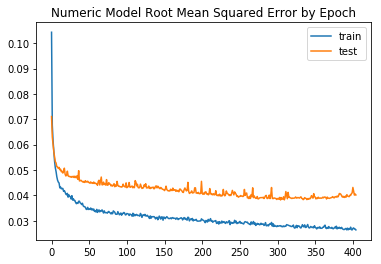

In [17]:
# Use best hyperparameters from the gridsearch to create a model for the numeric data

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

num_best_model = createModel(input_dim = num_best_params['input_dim'],
                             dropout_rate = num_best_params['dropout_rate'],
                             neurons = num_best_params['neurons'],
                             weight_constraint = num_best_params['weight_constraint'])

# Early stopping will reduce unnecessary epochs from being run. All models use this es callback except learned embedding models.
es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=100)

# Model checkpoint will save the best model based on the validation data's mse. Each model uses it's own checkpoint.
mc = ModelCheckpoint('num_best_model.h5', monitor='val_root_mean_squared_error', mode='min', save_best_only=True)

num_history = num_best_model.fit(num_enc_X_train, y_train,
                                 validation_data=(num_enc_X_test, y_test),
                                 epochs=1000, verbose=0, callbacks=[es, mc])

# Save model and predictions for combined model
saved_model = load_model('num_best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})
num_predict_train = saved_model.predict(num_enc_X_train)
num_predict_test = saved_model.predict(num_enc_X_test)
num_predict = saved_model.predict(num_test)

# Plot mse and validation mse to check performance
pyplot.title("Numeric Model Root Mean Squared Error by Epoch")
pyplot.plot(num_history.history['root_mean_squared_error'], label='train')
pyplot.plot(num_history.history['val_root_mean_squared_error'], label='test')
pyplot.legend()
pyplot.show()

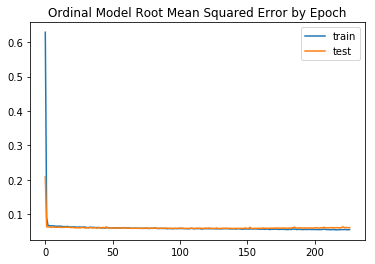

In [18]:
# Use best hyperparameters from the gridsearch to create a model for the ordinal data

ord_best_model = createModel(input_dim = ord_best_params['input_dim'],
                             dropout_rate = ord_best_params['dropout_rate'],
                             neurons = ord_best_params['neurons'],
                             weight_constraint = ord_best_params['weight_constraint'])

mc = ModelCheckpoint('ord_best_model.h5', monitor='val_root_mean_squared_error', mode='min', save_best_only=True)

ord_history = ord_best_model.fit(ord_enc_X_train, y_train,
                                 validation_data=(ord_enc_X_test, y_test),
                                 epochs=1000, verbose=0, callbacks=[es, mc])

# Save model and predictions for combined model
saved_model = load_model('ord_best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})
ord_predict_train = saved_model.predict(ord_enc_X_train)
ord_predict_test = saved_model.predict(ord_enc_X_test)
ord_predict = saved_model.predict(ord_test)

# Plot mse and validation mse to check performance
pyplot.title("Ordinal Model Root Mean Squared Error by Epoch")
pyplot.plot(ord_history.history['root_mean_squared_error'], label='train')
pyplot.plot(ord_history.history['val_root_mean_squared_error'], label='test')
pyplot.legend()
pyplot.show()

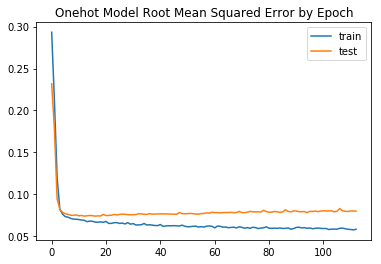

In [19]:
# Use best hyperparameters from the gridsearch to create a model for the onehot data

onehot_best_model = createModel(input_dim = onehot_best_params['input_dim'],
                             dropout_rate = onehot_best_params['dropout_rate'],
                             neurons = onehot_best_params['neurons'],
                             weight_constraint = onehot_best_params['weight_constraint'])

mc = ModelCheckpoint('onehot_best_model.h5', monitor='val_root_mean_squared_error', mode='min', save_best_only=True)

onehot_history = onehot_best_model.fit(onehot_enc_X_train, y_train,
                                 validation_data=(onehot_enc_X_test, y_test),
                                 epochs=1000, verbose=0, callbacks=[es, mc])

# Save model and predictions for combined model
saved_model = load_model('onehot_best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})
onehot_predict_train = saved_model.predict(onehot_enc_X_train)
onehot_predict_test = saved_model.predict(onehot_enc_X_test)
onehot_predict = saved_model.predict(onehot_test)

# Plot mse and validation mse to check performance
pyplot.title("Onehot Model Root Mean Squared Error by Epoch")
pyplot.plot(onehot_history.history['root_mean_squared_error'], label='train')
pyplot.plot(onehot_history.history['val_root_mean_squared_error'], label='test')
pyplot.legend()
pyplot.show()

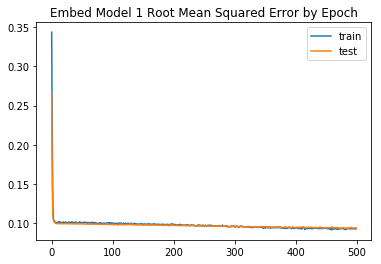

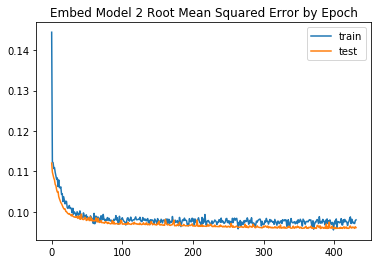

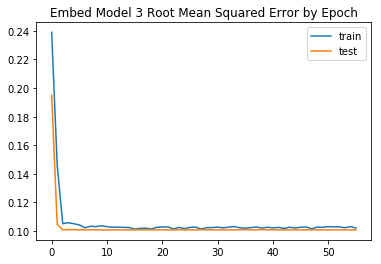

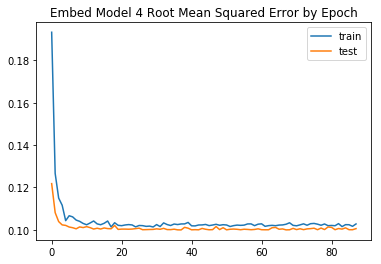

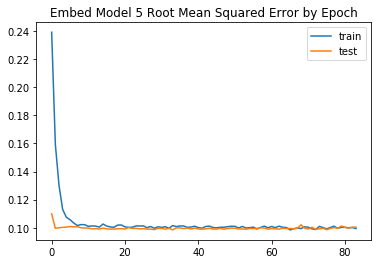

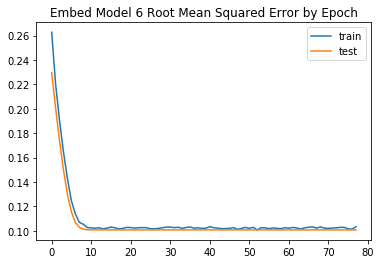

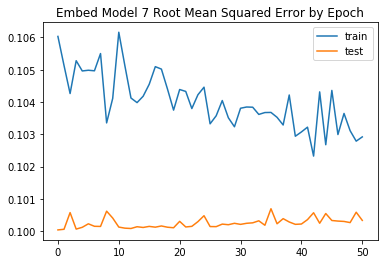

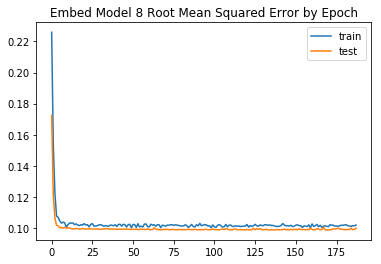

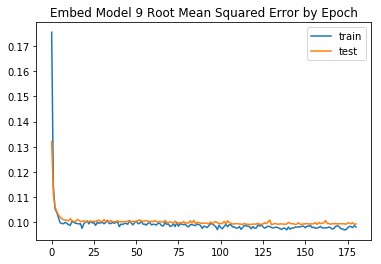

In [20]:
# Use best hyperparameters from the gridsearch to create a model for the learned embedding data

# Get feature lists for each dataset
emb_train_features = emb_enc_X_train.T
emb_test_features = emb_enc_X_test.T
emb_features = emb_test.T

# Create lists to hold predicitons for combined models
emb_predict_train = list()
emb_predict_test = list()
emb_predict = list()

# Change early stopping patience for shorter epoch search for embed models
es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=50)

# Iterate through the list of best hyperparameters for each learned embedding feature
for i in range(0, len(emb_best_params)):
    
    # Create a model for each feature
    emb_best_model = createModel(input_dim = 1,
                             dropout_rate = emb_best_params[i]['dropout_rate'],
                             neurons = emb_best_params[i]['neurons'],
                             weight_constraint = emb_best_params[i]['weight_constraint'])
    
    # Create a model checkpoint for each feature model
    model_name = 'emb_best_model_' + str(i) + '.h5'
    mc = ModelCheckpoint(model_name, monitor='val_root_mean_squared_error', mode='min', save_best_only=True)
    
    emb_history = emb_best_model.fit(emb_train_features[i], y_train,
                                     validation_data=(emb_test_features[i], y_test),
                                     epochs=500, verbose=0, callbacks=[es, mc])
    
    # Save model and predictions for combined model
    saved_model = load_model('emb_best_model_' + str(i) + '.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})
    emb_predict_train.append(saved_model.predict(emb_train_features[i]))
    emb_predict_test.append(saved_model.predict(emb_test_features[i]))
    emb_predict.append(saved_model.predict(emb_features[i]))
    
    # Plot mse and validation mse to check performance
    pyplot.title("Embed Model " + str(i+1) +  " Root Mean Squared Error by Epoch")
    pyplot.plot(emb_history.history['root_mean_squared_error'], label='train')
    pyplot.plot(emb_history.history['val_root_mean_squared_error'], label='test')
    pyplot.legend()
    pyplot.show()

In [21]:
# Use predictions from each model as input to combined model, then gridsearch hyperparameters for the combined model

# Concatenate predictions for the combined model
combined_train_predictions = np.concatenate((num_predict_train, 
                                             ord_predict_train, 
                                             onehot_predict_train, 
                                             np.concatenate(emb_predict_train, axis=1)),
                                            axis=1)

combined_test_predictions = np.concatenate((num_predict_test, 
                                             ord_predict_test, 
                                             onehot_predict_test, 
                                             np.concatenate(emb_predict_test, axis=1)),
                                            axis=1)

param_grid['input_dim'] = [combined_train_predictions.shape[1]]

# Grid search
combined_best_params = gridSearch(combined_train_predictions, y_train, param_grid, base_model=createModel, print_mode=2)

# To skip lengthy grid search for testing uncomment this and comment out grid search. These are last best params.
#combined_best_params = {'dropout_rate': 0.0, 'input_dim': 12, 'neurons': [10, 8], 'weight_constraint': 4}

Best: -0.030551 using {'dropout_rate': 0.0, 'input_dim': 12, 'neurons': [10, 8], 'weight_constraint': 2}


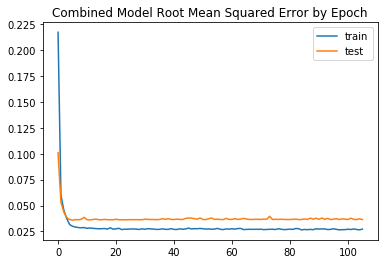

In [22]:
# Use best hyperparameters from the gridsearch to create a model for the combined data

combined_best_model = createModel(input_dim = combined_best_params['input_dim'],
                             dropout_rate = combined_best_params['dropout_rate'],
                             neurons = combined_best_params['neurons'],
                             weight_constraint = combined_best_params['weight_constraint'])

# Change early stopping patience back from embed models.
es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=100)
mc = ModelCheckpoint('combined_best_model.h5', monitor='val_root_mean_squared_error', mode='min', save_best_only=True)

combined_history = combined_best_model.fit(combined_train_predictions, y_train,
                                 validation_data=(combined_test_predictions, y_test),
                                 epochs=1000, verbose=0, callbacks=[es, mc])

# Plot mse and validation mse to check performance
pyplot.title("Combined Model Root Mean Squared Error by Epoch")
pyplot.plot(combined_history.history['root_mean_squared_error'], label='train')
pyplot.plot(combined_history.history['val_root_mean_squared_error'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# Combine predictions for competition data from each optimized model and use the optimized combined model to predict the competition data.

combined_final_model = load_model('combined_best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

combined_predictions = np.concatenate((num_predict, ord_predict, onehot_predict, np.concatenate(emb_predict, axis=1)),axis=1)
predictions = combined_final_model.predict(combined_predictions)

# Rescale
predictions = predictions * max_SalePrice
predictions = predictions.flatten()

submission = pd.DataFrame({'Id' : test.Id, 'SalePrice' : predictions})
submission.to_csv('my_submission.csv', index=False)